In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score as NMI

%matplotlib inline

In [30]:
import sys
sys.path.insert(1, "../utilities")
from plot_utils import *
from extract import *
from assigners import *
from effect_estimators import *
from VAT_simple import *
from MF import *
#from experimental import *

In [676]:
def get_masstimes(mass_time, inds=None):
    if inds is None:
        inds = np.arange(mass_time.shape[0])
    masstime = np.empty((len(inds),), dtype=object)
    for i, ind in enumerate(inds):
        masstime[i]=mass_time[ind,0] + "@" + mass_time[ind,1]
    return masstime


def map_cluster_ids(df, df_cluster, mt_col=' masstime', c_col=' clusterID'):
    df_new=df.copy()
    for row in range(df_new.shape[0]):
        mt = df_new.loc[row,mt_col]
        ind = np.where(df_cluster[mt_col]==mt)[0]
        label = df_cluster.loc[ind,c_col].values
        df_new.at[row,c_col] = label
    return df_new

def get_negatively_correlated_clusters(df, cluster_id = 'clusterID', th=0.75, min_size=2):
    df_new = df.copy()
    labels = df_new[cluster_id].to_numpy()
 
    luniq = np.unique(labels)
    lcounts = np.zeros((len(luniq),))
    for i, l in enumerate(luniq):
        lcounts[i] = np.where(labels==l)[0].shape[0]
    dict_clusters = dict(zip(luniq, lcounts))
    
    list_singular_vectors = []
    for i, label in enumerate(luniq):
        inds = np.where(labels==label)[0]
        cluster = df_new.iloc[inds,9:].to_numpy(dtype=float).T
        if cluster.shape[1] > 1:
            # represent the cluster with first singular vector
            # shift and scale the cluster to [0,1]
            #cluster = (cluster - np.min(cluster))/(np.max(cluster)-np.min(cluster))
            u, s, vh = np.linalg.svd(cluster, full_matrices=False)
            #u_init,v_init=nnd_svd_initialization(cluster, 2)
            #u, v, err = matrix_factorization(cluster, u_init, v_init, n_iter=1000, n_iter_inner=10, alpha=0.0002, beta=0.02)
            if np.corrcoef(u[:,0], cluster[:,0])[0,1] < 0:
                cluster = -u[:,0]
            else:
                cluster = u[:,0]
        else:
            cluster=cluster.reshape(-1,)
            # shift and scale the cluster to [0,1]
            #cluster = (cluster - np.min(cluster))/(np.max(cluster)-np.min(cluster))
        
        list_singular_vectors.append(cluster)
    dict_singular_vectors = dict(zip(luniq, list_singular_vectors))
    
    # create a dictionary of clusters, where keys are cluster labels
    # and values are labels of clusters that are negatively correlated.
    # The correlations are calculated between the first singular vectors
    # of the clusters.
    dict_neg_correlated = {}
    for i in dict_singular_vectors.keys():
        if dict_neg_correlated.get(i) is None:
            dict_neg_correlated[i] = []
        
        for j in dict_singular_vectors.keys():
            if i==j or j in dict_neg_correlated[i] or dict_clusters[j] < min_size:
                continue    
            else:
                corr = np.corrcoef(dict_singular_vectors[i], dict_singular_vectors[j])[0,1]
                if corr < -th:
                    dict_neg_correlated[i].append(j)
                    if dict_neg_correlated.get(j) is None:
                        dict_neg_correlated[j] = []
                    dict_neg_correlated[j].append(i)
                    
    ss=[]
    for key in dict_neg_correlated.keys():
        s=''
        for i, elem in enumerate(dict_neg_correlated[key]):
            if i==0:
                s += str(elem)
            else:
                s += ',' + str(elem)
         
        ss.append(s)      
        #dict_neg_correlated[key] = s
    #return dict_neg_correlated
    return dict(zip(dict_neg_correlated.keys(), ss))


In [4]:
fnum=0

# Data
pathGF = "../../../PARKINSONS/PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
df_GF = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

# Significance information
path_s = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
print(filenames_s[fnum])
df_s = pd.read_csv(path_s + filenames_s[fnum],sep=';')

path_out = "../../../PARKINSONS/PDproj/cellresults/ttest/withGF/only32/ALPHA0.05FC1.0MINVAR0.125/experimental/"

tle = filenamesGF[fnum].split('GF')[0]

masstime = np.unique(df_s[' masstime'].to_numpy())
data_significant=get_features(masstime, df_GF, True,[0,1,2])

Area = data_significant.iloc[3:,8:48]
groups = df_GF.iloc[0,8:48]
labels = LabelEncoder().fit_transform(groups)

data_X=data_significant.iloc[3:,:48]

cellsRPnegGFstatus.csv
cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv


In [5]:
#sorted_ind=np.argsort(data_significant.iloc[3:,5])
#data_significant=data_significant.iloc[sorted_ind+3,:]
data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
5,Reduced Glutathione,C10 H17 N3 O6 S,2,307.08442,306.07714,0.609,No MS2,[M-H]-1,22.156488084284803,22.424279255395426,...,22.71064097411695,23.75006289012101,23.370456794721267,23.28077131792212,23.620124399449285,22.869467356729697,23.782858059823745,24.00450069571074,23.412271201777354,23.32474683416169
7,Reduced Glutathione,C10 H17 N3 O6 S,1.74,307.08434,306.07706,0.913,No MS2,[M-H]-1,23.251795601807505,23.509163334558792,...,23.348650364674228,24.145229476313656,23.98321476112747,23.632515750033832,23.934705257679628,23.114699904857332,24.167128122163657,24.346850456627738,23.616989477849803,23.821658754447014
23,NaN,C41 H79 N6 O4 P,0.41,750.59035,749.58307,13.067,DDA for preferred ion,[M-H]-1,19.485135752931512,19.115175508065878,...,20.955791068838483,21.216946934774356,20.94104902506037,21.773418968255143,21.358175318797457,21.451483363326126,21.27747290490181,21.4434229388353,21.835035194328622,21.357431965477222
29,O-{[(2R)-3-(Henicosanoyloxy)-2-hydroxypropoxy]...,C27 H54 N O9 P,2.43,567.355,566.34772,10.608,No MS2,[M-H]-1,20.376913029563156,20.259040101217156,...,20.845448413429477,21.140612660787443,20.72939852877524,20.492011192215823,20.609273921253966,20.12665485359071,20.553430253620963,20.905394795962863,20.50127545808506,21.11722068147598
38,NaN,C44 H82 N5 O5 P,0.73,791.60593,790.59866,14.324,DDA for preferred ion,[M-H]-1,19.722912988852563,19.161734657442842,...,21.59705324861394,21.808809909480946,21.42590457184678,22.1948231303575,21.590711350770547,21.810683290718035,21.53910283160454,21.959393562251595,22.3163521881364,22.190049863255602


### Correlation distance CD $\in$ [0,2]

**Value 0 corresponds to fully positively correlated features (cor=1), value 2 fully negatively correlated features (cor=-1). Values close to 1 are uncorrelated.**

In [761]:
X=data_X.iloc[:,8:].to_numpy(dtype=float).T

# Correlation matrix with ddof=0 (just holding a fixed rule)
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(X)
COR = np.cov(X_std.T, ddof=1)

# Make a distance matrix from the correlation matrix COR
#mask = np.ones_like(COR) # change mask e.g., to account for temporal proximity
#CD = 1 - mask*COR
CD = 1 - COR
# make sure the diagonal is zero and the matrix is PD
CD = np.maximum(CD, CD.T)
CD -= np.diag(CD.diagonal())
CD = np.clip(CD,0,2)
cd_matrix = squareform(CD,force='tovector')

print(tle, 'data has',X.shape[1], ' features')
print('\nRange of values in cor-dist:', CD.min(),'-',np.round(CD.max(),2))

cellsRPneg data has 56  features

Range of values in cor-dist: 0.0 - 1.99


### A rough visualization of clustering tendency based on cor-dist

**Can typically recognize 2 main structures corresponding to typical test patterns: typically majority of the form (aSYN,UT) low, (IFNg, comb) high, and minority (aSYN,UT) high, (IFNg, comb) low. These two patterns are negatively correlated.**

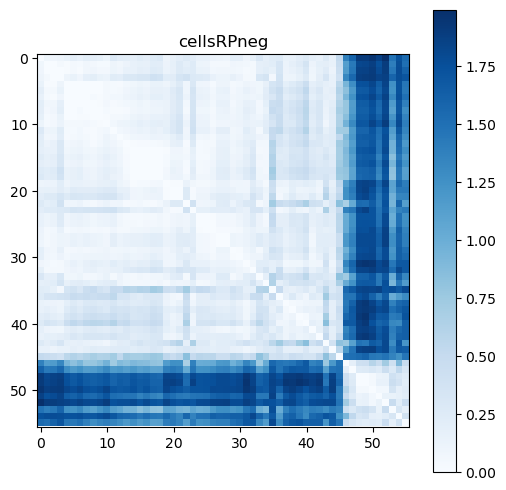

In [762]:
plt.figure(figsize=(6,6))
plt.imshow(VAT(CD), cmap='Blues')
plt.colorbar()
plt.title(tle)
plt.show()
#pyclustertend.vat(CD, figure_size=(6,6))
#plt.title(tle)
#plt.show()

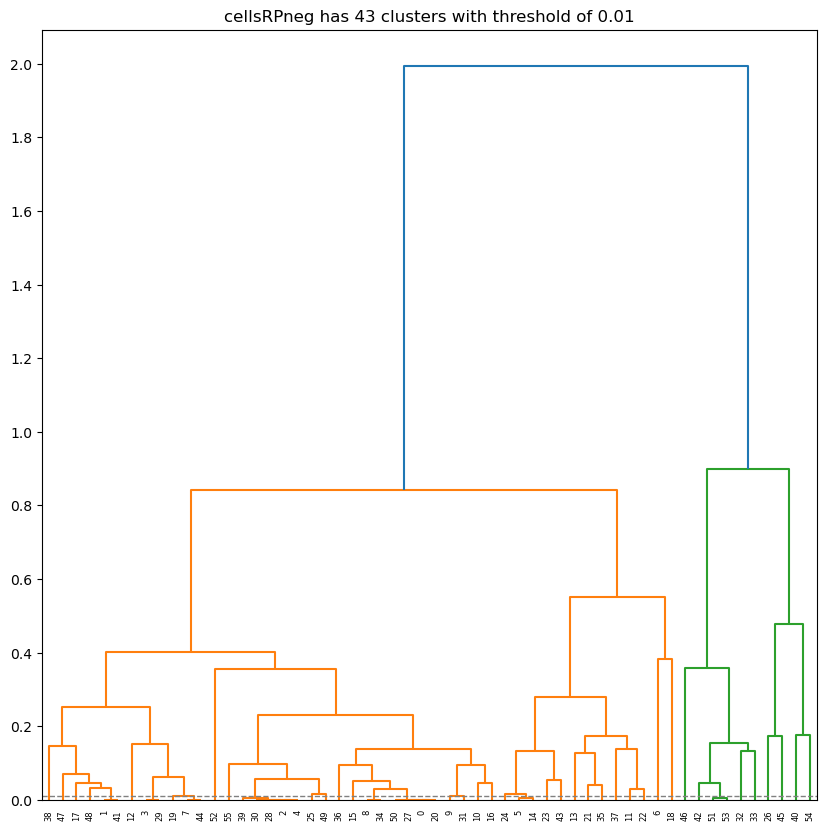

In [763]:
th=0.01
plt.figure(figsize=(10,10))
link_complete = hierarchy.linkage(cd_matrix, method='complete',  optimal_ordering=False)
labels_complete=hierarchy.fcluster(link_complete, t=th, criterion='distance')
hierarchy.dendrogram(link_complete, truncate_mode='none', labels=np.asarray(np.arange(CD.shape[0])))
plt.axhline(y=th, c='grey', lw=1, linestyle='dashed')
plt.yticks(np.arange(0,2.1,0.2))
plt.title("{} has {} clusters with threshold of {}".format(tle, np.unique(labels_complete).shape[0], th))
plt.show()

In [764]:
luniq = np.unique(labels_complete)
len(luniq)

43

In [765]:
# just the significant features
data_with_labels = data_X.copy()
data_with_labels.insert(1, ' clusterID', labels_complete)
#data_with_labels.sort_values(by=[' clusterID'], inplace=True)

# add a column to the dataframe that indicates to which, if any, cluster is negatively correlated
dict_neg_correlated = get_negatively_correlated_clusters(data_with_labels, cluster_id = ' clusterID', th=0.9, min_size=1)
neg_correlated = np.empty((data_with_labels.shape[0],), dtype=object)
for row in range(data_with_labels.shape[0]):
    label = data_with_labels.iloc[row,1]
    neg_correlated[row] = dict_neg_correlated[label]

data_with_labels.insert(2, ' neg_cor_clusters', neg_correlated)

In [766]:
neg_correlated

array(['', '', '', '', '', '', '', '', '', '', '', '', '36,37', '', '',
       '', '', '', '', '', '', '35', '35', '', '', '', '', '', '', '', '',
       '', '9', '', '', '', '', '', '', '', '', '', '4,9', '', '', '', '',
       '35,36', '', '', '', '4,27,31', '', '4,27,31', '', ''],
      dtype=object)

In [767]:
data_with_labels.head()

,0,clusterID,neg_cor_clusters,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
5,Reduced Glutathione,15,,C10 H17 N3 O6 S,2,307.08442,306.07714,0.609,No MS2,[M-H]-1,...,22.71064097411695,23.75006289012101,23.370456794721267,23.28077131792212,23.620124399449285,22.869467356729697,23.782858059823745,24.00450069571074,23.412271201777354,23.32474683416169
7,Reduced Glutathione,1,,C10 H17 N3 O6 S,1.74,307.08434,306.07706,0.913,No MS2,[M-H]-1,...,23.348650364674228,24.145229476313656,23.98321476112747,23.632515750033832,23.934705257679628,23.114699904857332,24.167128122163657,24.346850456627738,23.616989477849803,23.821658754447014
23,NaN,10,,C41 H79 N6 O4 P,0.41,750.59035,749.58307,13.067,DDA for preferred ion,[M-H]-1,...,20.955791068838483,21.216946934774356,20.94104902506037,21.773418968255143,21.358175318797457,21.451483363326126,21.27747290490181,21.4434229388353,21.835035194328622,21.357431965477222
29,O-{[(2R)-3-(Henicosanoyloxy)-2-hydroxypropoxy]...,6,,C27 H54 N O9 P,2.43,567.355,566.34772,10.608,No MS2,[M-H]-1,...,20.845448413429477,21.140612660787443,20.72939852877524,20.492011192215823,20.609273921253966,20.12665485359071,20.553430253620963,20.905394795962863,20.50127545808506,21.11722068147598
38,NaN,10,,C44 H82 N5 O5 P,0.73,791.60593,790.59866,14.324,DDA for preferred ion,[M-H]-1,...,21.59705324861394,21.808809909480946,21.42590457184678,22.1948231303575,21.590711350770547,21.810683290718035,21.53910283160454,21.959393562251595,22.3163521881364,22.190049863255602


### Compile the assignments and update the dataframe with significant features

In [768]:
# Make a copy of the significance data
df_temp=df_s.copy()

df_temp.insert(1, ' clusterID', np.zeros((df_s.shape[0]),dtype=int))
df_temp.insert(2, ' neg_cor_clusters', np.empty((df_s.shape[0]),dtype=object))

# Make cluster assignment dataframe
clustered_features = pd.DataFrame({' masstime':get_masstimes(data_X.iloc[:,4:6].to_numpy()),
                                   ' clusterID':labels_complete})
# Do the same with negative correlation information
clustered_features_neg = pd.DataFrame({' masstime':get_masstimes(data_X.iloc[:,4:6].to_numpy()),
                                      ' neg_cor_clusters':neg_correlated})

In [769]:
check=clustered_features.join(clustered_features_neg.set_index(' masstime'), on=' masstime')
check.sort_values(by=[' clusterID'], inplace=True)
check.head()

,masstime,clusterID,neg_cor_clusters
1,306.07706@0.913,1,
41,653.1407@0.862,1,
48,635.14339@0.912,2,
17,133.01332@0.61,3,
47,530.05715@0.897,4,"35,36"


In [770]:
# Map the assignments and make a new dataframe
df_new=map_cluster_ids(df_temp, clustered_features, mt_col=' masstime', c_col=' clusterID')
df_new=map_cluster_ids(df_new, clustered_features_neg, mt_col=' masstime' , c_col=' neg_cor_clusters')
df_new.sort_values(by=[' clusterID'], inplace=True)

In [771]:
df_new.head()

,compound,clusterID,neg_cor_clusters,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
38,NaN,1,,653.1407@0.862,aSYN--INFg,0.000005,0.001598,0.009516,-1.989279,-0.216336,0,0
15,Reduced Glutathione,1,,306.07706@0.913,aSYN--comb.,0.000000,0.000232,0.000443,-1.190763,0.273846,0,0
23,NaN,1,,653.1407@0.862,aSYN--comb.,0.000001,0.000865,0.003050,-2.150083,0.761639,0,0
21,NaN,1,,653.1407@0.862,comb.--UT,0.000001,0.000509,0.001585,2.058949,0.469270,0,0
35,NaN,1,,653.1407@0.862,INFg--UT,0.000004,0.001461,0.008166,1.898145,-0.508705,0,0


In [775]:
df_new.head(40)

,compound,clusterID,neg_cor_clusters,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
38,NaN,1,,653.1407@0.862,aSYN--INFg,0.000005,0.001598,0.009516,-1.989279,-0.216336,0,0
15,Reduced Glutathione,1,,306.07706@0.913,aSYN--comb.,0.000000,0.000232,0.000443,-1.190763,0.273846,0,0
23,NaN,1,,653.1407@0.862,aSYN--comb.,0.000001,0.000865,0.003050,-2.150083,0.761639,0,0
21,NaN,1,,653.1407@0.862,comb.--UT,0.000001,0.000509,0.001585,2.058949,0.469270,0,0
35,NaN,1,,653.1407@0.862,INFg--UT,0.000004,0.001461,0.008166,1.898145,-0.508705,0,0
33,Reduced Glutathione,1,,306.07706@0.913,aSYN--INFg,0.000004,0.001386,0.007580,-1.031581,-0.160979,0,0
43,Reduced Glutathione,1,,306.07706@0.913,INFg--UT,0.000006,0.001848,0.012353,1.040676,-0.230272,0,0
18,Reduced Glutathione,1,,306.07706@0.913,comb.--UT,0.000000,0.000414,0.001043,1.199859,0.204553,0,0
47,NaN,2,,635.14339@0.912,INFg--UT,0.000010,0.002738,0.021959,1.964373,0.329225,0,0
27,NaN,2,,635.14339@0.912,comb.--UT,0.000002,0.000976,0.004507,2.245379,0.369241,0,0


### Write new results

In [371]:
#df_new.to_csv(path_out + fname, sep=';', index=None)

### Checks

In [779]:
id1, id2 = 9, 36
cluster_ind = np.where(np.logical_or(data_with_labels[' clusterID']==id1,data_with_labels[' clusterID']==id2))[0]
cluster_ids = data_with_labels.iloc[cluster_ind,1].to_numpy(dtype=int)
cluster_times = data_with_labels.iloc[cluster_ind,7].to_numpy(dtype=float)
cluster_mass = data_with_labels.iloc[cluster_ind,6].to_numpy(dtype=float)
cluster_masstimes = ["{}@{} ID: {}".format(m,t,cluster_ids[i]) for i,(m,t) in enumerate(zip(cluster_mass,cluster_times))]

cluster = data_with_labels.iloc[cluster_ind,10:50].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[ 0.598 10.692]


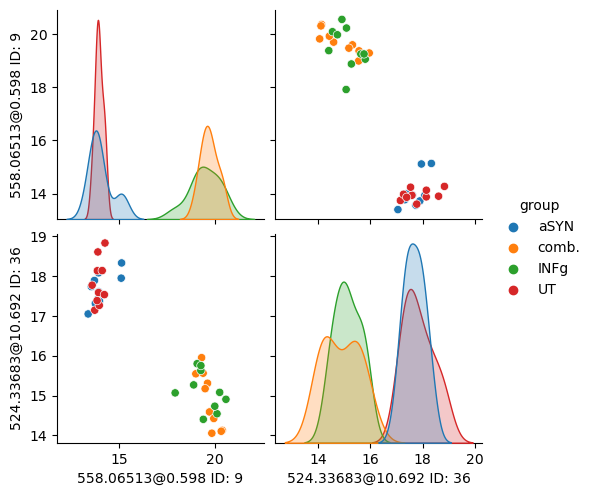

In [780]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

### Visualize individual clusters

In [417]:
inds=np.argsort(labels_complete)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=labels_complete[inds])
luniq=np.unique(labels_complete[inds])

In [418]:
k=luniq[0]

cluster_ind = np.where(labels_complete[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[0.912 0.913 0.862 0.61 ]


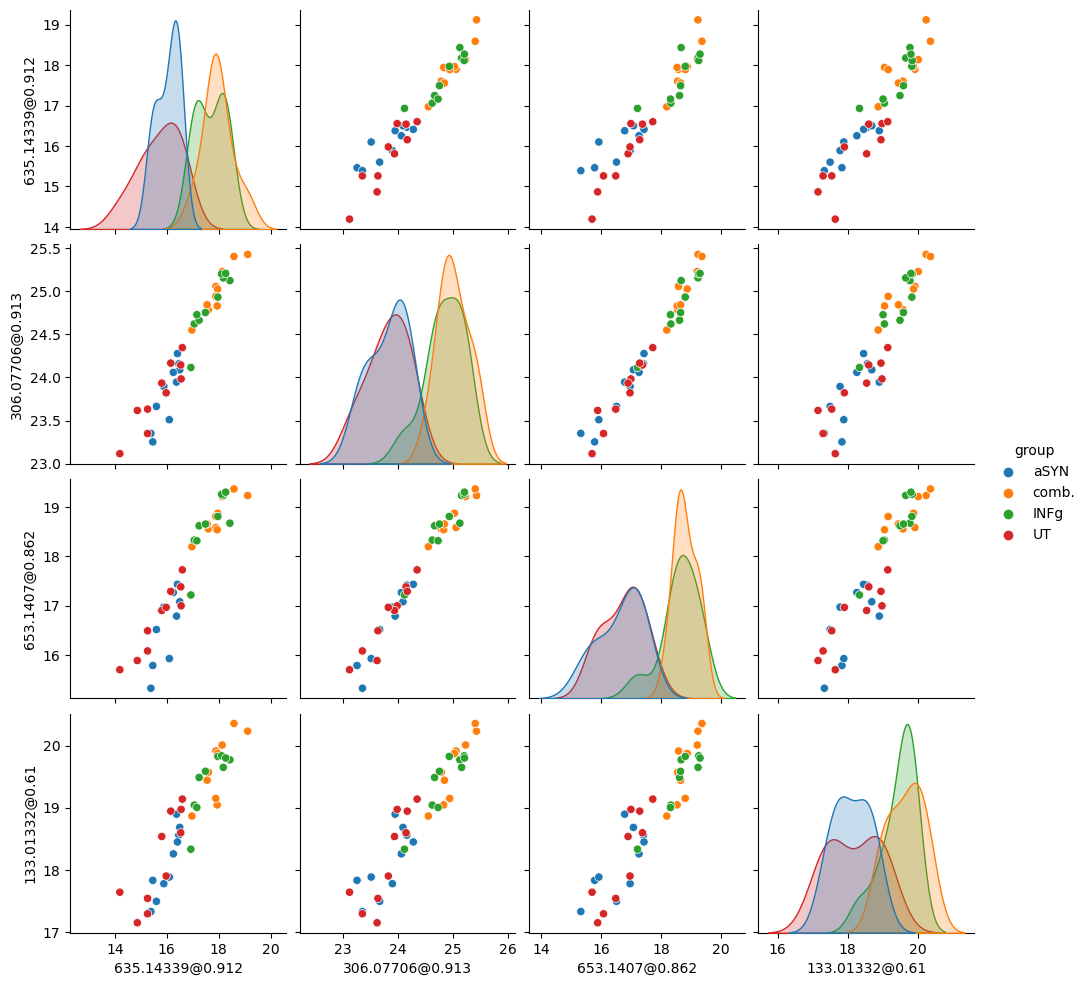

In [419]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

In [58]:
df_new.iloc[np.where(df_new[' clusterID']==k)[0],:]

,compound,clusterID,masstime,test,p_orig,p_FDR,p_Bonf,FC,ms,gaps1,gaps2
15,Reduced Glutathione,1,306.07706@0.913,aSYN--comb.,0.000000,0.000232,0.000443,-1.190763,0.273846,0,0
16,NaN,1,635.14339@0.912,aSYN--comb.,0.000000,0.000232,0.000480,-1.922021,0.469243,0,0
18,Reduced Glutathione,1,306.07706@0.913,comb.--UT,0.000000,0.000414,0.001043,1.199859,0.204553,0,0
21,NaN,1,653.1407@0.862,comb.--UT,0.000001,0.000509,0.001585,2.058949,0.469270,0,0
22,NaN,1,635.14339@0.912,aSYN--INFg,0.000001,0.000815,0.002772,-1.641015,0.429227,0,0
23,NaN,1,653.1407@0.862,aSYN--comb.,0.000001,0.000865,0.003050,-2.150083,0.761639,0,0
27,NaN,1,635.14339@0.912,comb.--UT,0.000002,0.000976,0.004507,2.245379,0.369241,0,0
29,NaN,1,530.05715@0.897,comb.--UT,0.000002,0.000993,0.004882,3.934630,1.285213,0,6
33,Reduced Glutathione,1,306.07706@0.913,aSYN--INFg,0.000004,0.001386,0.007580,-1.031581,-0.160979,0,0
34,NaN,1,133.01332@0.61,aSYN--comb.,0.000004,0.001386,0.007560,-1.527943,-0.030330,0,0


In [59]:
cluster_names

array(['Reduced Glutathione', 'nan', 'nan', 'nan', 'nan'], dtype='<U19')

In [60]:
cluster_masstimes

['306.07706@0.913',
 '133.01332@0.61',
 '635.14339@0.912',
 '530.05715@0.897',
 '653.1407@0.862']

In [61]:
mts, ps, ts, es = extract_pvalues(df_s,cluster_masstimes, pvalue_col=' p_FDR',head='')
display_pvalues(mts, ps, ts, es, tle)

cellsRPneg
-----------------------
Peak: 306.07706@0.913
P-values: [0.000232, 0.000414, 0.001386, 0.001848]
Tests: ['aSYN--comb.', 'comb.--UT', 'aSYN--INFg', 'INFg--UT']
Effects: [-1.190763, 1.199859, -1.031581, 1.040676]
-----------------------
Peak: 133.01332@0.61
P-values: [0.001386, 0.003994, 0.013097, 0.03844]
Tests: ['aSYN--comb.', 'aSYN--INFg', 'comb.--UT', 'INFg--UT']
Effects: [-1.527943, -1.315755, 1.472697, 1.260509]
-----------------------
Peak: 635.14339@0.912
P-values: [0.000232, 0.000815, 0.000976, 0.002738]
Tests: ['aSYN--comb.', 'aSYN--INFg', 'comb.--UT', 'INFg--UT']
Effects: [-1.922021, -1.641015, 2.245379, 1.964373]
-----------------------
Peak: 530.05715@0.897
P-values: [0.000993, 0.001471, 0.007032, 0.010608]
Tests: ['comb.--UT', 'aSYN--comb.', 'INFg--UT', 'aSYN--INFg']
Effects: [3.93463, -3.732994, 3.295271, -3.093636]
-----------------------
Peak: 653.1407@0.862
P-values: [0.000509, 0.000865, 0.001461, 0.001598]
Tests: ['comb.--UT', 'aSYN--comb.', 'INFg--UT', 'aSY

## Alternative approach using a mixture of Von Mises Fisher distributions, or spherical kmeans 

In [18]:
x=X_std.T

In [63]:
K=len(luniq)
xinit=x[np.random.choice(range(x.shape[0]),K),:]
centroids, dist, predictions = kmeans_spherical_v2(x, K, 1000, xinit)
centroids.shape[0]

21

In [64]:
NMI(labels_complete, predictions)

0.8599101694009053

In [32]:
centroids

array([[ 0.01853818,  0.06509062, -0.13553732, ..., -0.20259301,
        -0.15869412, -0.07491774],
       [-0.17975048, -0.1708161 , -0.16062406, ..., -0.14200062,
        -0.16085002, -0.14028602],
       [-0.22319731, -0.26071553, -0.06794866, ..., -0.06541877,
        -0.18030832, -0.02717054],
       ...,
       [-0.05507034, -0.09557675, -0.05361294, ..., -0.16481921,
        -0.14631325, -0.1359418 ],
       [ 0.08880237,  0.14117861, -0.08396233, ..., -0.07063078,
        -0.09679427, -0.08632264],
       [-0.06300204, -0.10303122, -0.18884351, ..., -0.17182978,
        -0.02201925,  0.03062516]])

In [42]:
NMI(labels_complete, predictions)

0.8331836775826519

In [47]:
inds=np.argsort(predictions)
result = data_X.iloc[inds,:]
result.insert(loc=len(result.columns), column='labels_complete', value=predictions[inds])
luniq=np.unique(predictions[inds])

In [50]:
k=luniq[1]

cluster_ind = np.where(predictions[inds]==k)[0]
cluster_names = result.iloc[cluster_ind,0].to_numpy(dtype=str)
cluster_times = result.iloc[cluster_ind,5].to_numpy(dtype=float)
cluster_mass = result.iloc[cluster_ind,4].to_numpy(dtype=float)
cluster_masstimes = ["{}@{}".format(m,t) for m,t in zip(cluster_mass,cluster_times)]

cluster = result.iloc[cluster_ind,8:48].to_numpy(dtype=float).T

df_cluster = pd.DataFrame(cluster, columns = cluster_masstimes)
df_cluster['group']=groups.to_numpy(dtype=str)
print(cluster_times)

[0.603 0.604 0.603]


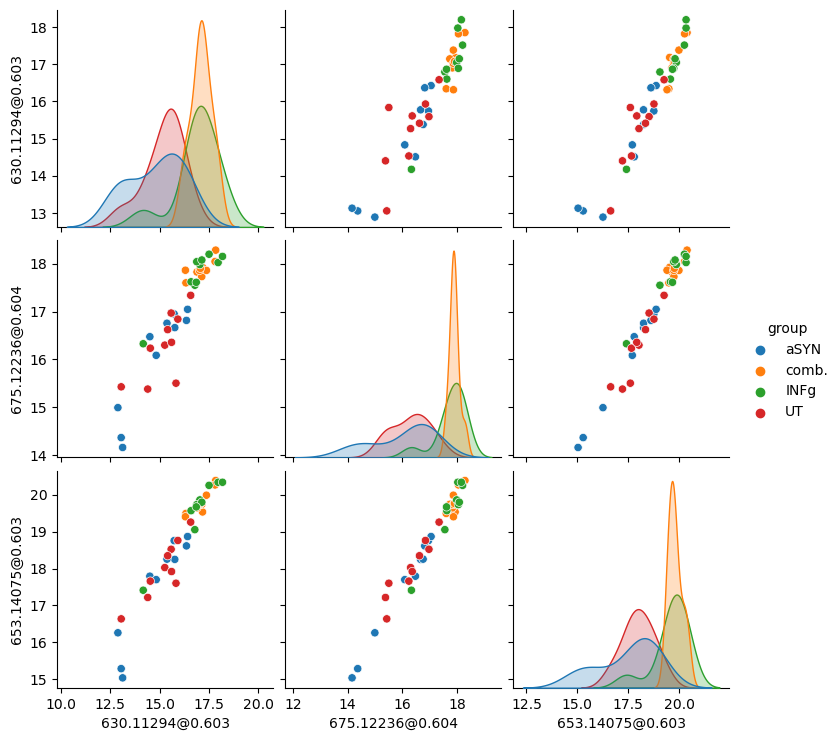

In [51]:
complete_pairplot(df_cluster, group_col='group', kind='kde', palette=None)

### Compile the data with column for cluster labels

In [56]:
colnames=['labels']
colnames.extend(list(df_GF.iloc[2,:8]))
colnames.extend(list(groups))

In [58]:
data_with_labels = data_X.copy()
data_with_labels.insert(0, 'labels', labels_complete)
data_with_labels.columns=colnames
data_with_labels.head(2)

,labels,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],MS2,Reference Ion,aSYN,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT
5,7,Reduced Glutathione,C10 H17 N3 O6 S,2,307.08442,306.07714,0.609,No MS2,[M-H]-1,22.156488084284803,...,22.71064097411695,23.75006289012101,23.370456794721267,23.28077131792212,23.620124399449285,22.869467356729697,23.782858059823745,24.00450069571074,23.412271201777354,23.32474683416169
7,1,Reduced Glutathione,C10 H17 N3 O6 S,1.74,307.08434,306.07706,0.913,No MS2,[M-H]-1,23.251795601807505,...,23.348650364674228,24.145229476313656,23.98321476112747,23.632515750033832,23.934705257679628,23.114699904857332,24.167128122163657,24.346850456627738,23.616989477849803,23.821658754447014


In [79]:
def get_latents(model, names, topics=None, n_top_words=10):
    word_dict = {}
    if topics is None:
        topics = ['Topic{}'.format(str(i)) for i in range(model.components_.shape[0])]
    feature_names = names
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        #top_features_ind = np.flip(top_features_ind)
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

In [63]:
features = data_with_labels.iloc[:,9:].to_numpy().T

In [87]:
# features = obs x compounds ~ abs x latents x (features x latents).T
lsi_model = TruncatedSVD(n_components=2).fit(features)
lsi_features = lsi_model.transform(features)

In [92]:
lsi_model_left = TruncatedSVD(n_components=2).fit(features.T)
lsi_features_left = lsi_model_left.transform(features.T)

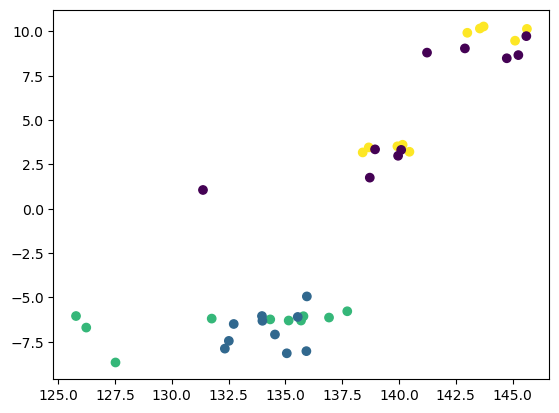

In [88]:
plt.scatter(lsi_features[:,0],lsi_features[:,1], c=LabelEncoder().fit_transform(groups))

In [90]:
get_latents(lsi_model, labels_complete, n_top_words=10)

,Topic0,Topic1
0,1,4
1,7,1
2,5,16
3,5,17
4,3,12
5,12,14
6,19,14
7,7,12
8,3,13
9,10,2


In [89]:
get_latents(lsi_model, list(data_with_labels.Name), n_top_words=10)

,Topic0,Topic1
0,Reduced Glutathione,"[(2R,3S,4R,5R)-5-(6-Amino-9H-purin-9-yl)-3,4-d..."
1,Reduced Glutathione,NaN
2,NaN,"stigmastane-3beta,5alpha,6beta-triol"
3,NaN,NaN
4,O-{[(2R)-3-(Henicosanoyloxy)-2-hydroxypropoxy]...,"(19R)-25-Amino-22-hydroxy-22-oxido-17,21,23-tr..."
5,NaN,NaN
6,NaN,Dilauryl citrate
7,NaN,1-hexadecanoyl-2-[(Z)-octadec-9-enoyl]-sn-glyc...
8,1-Oleoyl-2-hydroxy-sn-glycero-3-PE,NaN
9,NaN,NaN


In [96]:
get_latents(lsi_model_left, list(groups), n_top_words=20)

,Topic0,Topic1
0,comb.,aSYN
1,INFg,UT
2,INFg,UT
3,comb.,UT
4,INFg,UT
5,comb.,UT
6,comb.,aSYN
7,comb.,UT
8,INFg,UT
9,INFg,aSYN
